# Метрики качества

Рассмотрим основные метрики качества для классификаторов. Речь пойдет о: 

1. Матрица ошибок
2. Accuracy (доля правильных ответов)
3. Precision (точность)
4. Recall (полнота) 
5. F-score (F-мера)
6. Кривая Precision-recall
7. Кривая ROC.

Изучать данные показатели будем сразу на практическом примере - german credit data (я уже писал о ней в статье про кредитный скорринг). Скачать версию с моими именами столбцов можно [здесь](http//:www.glebmikhaylov.com). Без всяких дополнительных объяснений я создам модель на основе логистической регрессии, которая будет предсказывать вероятность дефолта клиента.

In [1]:
import pandas as pd
import numpy as np
from __future__ import division
import random
random.seed(1)
df = pd.read_csv('germancredit.csv')
df.columns

Index([u'Default', u'checkingstatus1', u'duration', u'history', u'purpose',
       u'amount', u'savings', u'employ', u'installment', u'status', u'others',
       u'residence', u'property', u'age', u'otherplans', u'housing', u'cards',
       u'job', u'liable', u'tele', u'foreign'],
      dtype='object')

Тренировать модель я буду примерно так же, как делал в посте про кредитный дефолт.

In [2]:
from sklearn.cross_validation import train_test_split
from patsy import dmatrices

formula = 'Default~C(checkingstatus1)+duration+C(purpose)+\
amount+C(savings)+C(employ)+installment+\
C(property)+age+C(otherplans)+\
C(housing)+cards+C(tele)+C(foreign)'
def test_train(formula, df):
    y,X = dmatrices(formula,df, return_type="dataframe")
    y = pd.np.ravel(y) # перобразуем y в одномерный массив
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    return y, X, X_train, X_test, y_train, y_test
y, X, X_train, X_test, y_train, y_test = test_train(formula, df)

Можно обучить модель.

In [3]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

И вот у нас есть модель, которая предсказывает вероятность дефолта клиента. Можно посмотреть, что она предскажет на тестовых данных.

In [4]:
model.predict_proba(X_test)[:,1][:10]

array([ 0.57533325,  0.06677284,  0.05149072,  0.6833485 ,  0.46046416,
        0.2308643 ,  0.11024943,  0.11448559,  0.04988511,  0.69050478])

Данный вывод показывает вероятность дефолта для первых десяти клиентов из тестовый выборки. Но нам нужно четко решить к какому классу относиться клиент: к 0 (хороший) или 1 (плохой). Для этого используется **порог** (threshold), давайте для начала зададим его равным 0.5. Это означает, что если вероятность дефолта больше 0.5, то мы будем считать клиента дефолтным. Теперь можно определить предсказанные классы, сравнить их с реальными и посмотреть  - в скольки случаях модель определила класс правильно.

In [5]:
y_pred = model.predict_proba(X_test)[:,1]
y_threshold = y_pred > 0.5
np.mean(y_threshold == y_test)

0.73666666666666669

Это и есть показатель **accuracy** или доля правильных ответов. Хорош ли этот показатель? Давайте разбираться дальше. Построим матрицу ошибок. Я сделаю для этого довольно громоздкую функцию, но она поможет лучше понять матрицу.

In [6]:
def error_matrix(y_act,y_pred,layout='df'):
    """Возвращает матрицу ошибок в одном из форматов"""
    df = pd.DataFrame({'pred':y_pred,'true':y_act})
    TP = len(df[(df['pred']==1)&(df['true']==1)])
    FN = len(df[(df['pred']==0)&(df['true']==1)])
    FP = len(df[(df['pred']==1)&(df['true']==0)])
    TN = len(df[(df['pred']==0)&(df['true']==0)])
    
    if layout == 'df':
        return pd.DataFrame([[TP,FP],
                        [FN,TN]],
                       index=['Предсказанный положительный',
                              'Предсказанный отрицательный'],
                       columns=['Реально положительный',
                                'Реально отрицательный'])
    elif layout == 'dict':
        return dict(zip(['TP','FP','FN','TN'],[TP, FP, FN, TN]))
    else:
        raise ValueError('Incorrect layout format.')

In [7]:
matrix = error_matrix(y_test,y_threshold)
matrix

,Реально положительный,Реально отрицательный
Предсказанный положительный,40,33
Предсказанный отрицательный,46,181


Чтобы было легче понимать эту матрицу, я выведу вспомогательныу таблицу.

In [8]:
pd.options.display.max_colwidth = 100
help_table = pd.DataFrame([[['True positive (ТP)','Положительное срабатывание'],
                            ['False positive (FP)','Ложное срабатыватение','Ошибка II']],
                           [['False negative (FN)','Ложный пропуск','Ошибка I'],
                            ['True negative (TN)','Верный пропуск']]],
                          index=['Предсказанный положительный',
                                 'Предсказанный отрицательный'],
                          columns=['Реально положительный',
                                   'Реально отрицательный'])
help_table

,Реально положительный,Реально отрицательный
Предсказанный положительный,"[True positive (ТP), Положительное срабатывание]","[False positive (FP), Ложное срабатыватение, Ошибка II]"
Предсказанный отрицательный,"[False negative (FN), Ложный пропуск, Ошибка I]","[True negative (TN), Верный пропуск]"


Всего четыре типа ситуации:
- классификатор правильно определил объект объект класса 1. Это **верное срабатывание** или True Positive. В нашем случае 40 положительных срабатываний;
- классификатор присвоил объекту класса 1 класс 0, он пропустил положительный класс. Это называется **ложным пропуском**, False negative или ошибкой первого рода. В нашем случае это 46;
- классификатор определяет нулевой (или отрицательные объект) как положительный, т.е. срабатывает в случае когда этого делать не надо. Это **ложное срабатывание**, ошибка второго рода или False positive. В нашем случае получилось 34;
- классификатор верно определят нулевой класс объекта. Это **верный пропуск** или True Negative. И у нас это 181.

Давайте проанализируем. Сразу видно, что из всех положительных объектов предсказанных классификатором (40+33) только 40 действительно являются положительными. Можно рассчитать долю этих объектов: 40/(40+33) = 0.55. Этот показатель называется **точность** или precision и рассчитывается следующим образом.

$$ precision = \frac{TP}{TP+FP}$$

Сделаем краткую вспомогательную табличку, выведем матрицу ошибок в виде словаря и рассчитаем precision по-человечески.

In [9]:
help_table2 = pd.DataFrame([['TP','FP'],['FN','TN']],
                           index=['1','0'],columns=['1','0'],)
help_table2

,1,0
1,TP,FP
0,FN,TN


Для удобства назовем словарь с ошибками просто d.

In [10]:
d = error_matrix(y_test,y_threshold,'dict')
d

{'FN': 46, 'FP': 33, 'TN': 181, 'TP': 40}

In [11]:
precision = d['TP']/(d['TP']+d['FP'])
precision

0.547945205479452

Давайте снова взглянем на нашу матрицу ошибок.

In [12]:
matrix

,Реально положительный,Реально отрицательный
Предсказанный положительный,40,33
Предсказанный отрицательный,46,181


Из всех реально положительных объектов (40+46) классификатор определил 40. Рассчитаем долю: 40/(40+46)=0.47. Этот показатель называется **полнота** или recall. Полнота показывает какое количество положительных объектов выделяет классификатор:

$$recall = \frac{TP}{TP+FN}$$

In [13]:
recall =  d['TP']/(d['TP']+d['FN'])
recall

0.46511627906976744

Что же получилось? При достаточно высокой доле правильных ответов (0.74), наш классификатор имеет точность 0.55 и полноту 0.47.

Давайте представим, что дав кредит хорошему клиенты мы зарабоетаем 0.2, а выдав плохому теряем 1. Какую прибыль принесла бы наша модель, если средний чек кредита равен например 100 000 руб. Снова выведем матрицу ошибок.

In [14]:
matrix

,Реально положительный,Реально отрицательный
Предсказанный положительный,40,33
Предсказанный отрицательный,46,181


Получатся, что мы заработем:

In [15]:
(181*0.2 - 46*1) * 100000

-979999.9999999998

Нда, не очень. Т.е мы дали кредит 180 хорошему клиенту и 46 плохим. Давайте подумаем можно ли как-то улучшить классификатор не меняя саму модель? Да - можно изменить порог. в данном случае выдача кредита плохому клиенту обходиться гораздо дороже, чем пропуск хорошего - значит порог нужно понижать (или повышать полноту классификатора). Давойте следаем это и установим порог равный 0.4.

In [16]:
y_threshold = y_pred > 0.4
np.mean(y_threshold == y_test)

0.7533333333333333

Ого! Доля правильных ответов возросла! Давайте взглянем на матрицу ошибок, точность и полноту.

In [17]:
error_matrix(y_test,y_threshold)

,Реально положительный,Реально отрицательный
Предсказанный положительный,56,44
Предсказанный отрицательный,30,170


In [18]:
d = error_matrix(y_test,y_threshold,'dict')
print d['TP']/(d['TP']+d['FP'])
print d['TP']/(d['TP']+d['FN'])

0.56
0.651162790698


Точность и полнота повысились. Что произошло с прибылью?

In [19]:
(170*0.2 - 30*1) * 100000

400000.0

Уже гораздо лучше! Кстати, есть метрика, которая объединяет точность и полноту. Рассчитывается она как гармоническое среднее между точностью и полнотой и называется **F-мера**:

$$F = 2*\frac{precision*recall}{precision+recall} $$

Чтобы не вычислять эти и дальше эти параметры вручную воспользуемся функцией classification_report из sklearn.

In [20]:
from sklearn.metrics import classification_report

In [21]:
print classification_report(y_test,y_threshold)

             precision    recall  f1-score   support

        0.0       0.85      0.79      0.82       214
        1.0       0.56      0.65      0.60        86

avg / total       0.77      0.75      0.76       300



В тотале здесь выводятся взвешенные показателя для обоих классов. Давайте еще понизим порог. 

In [22]:
y_threshold = y_pred > 0.3
print 'accuracy = ', np.mean(y_threshold == y_test)
print classification_report(y_test,y_threshold)
print error_matrix(y_test,y_threshold)

accuracy =  0.69
             precision    recall  f1-score   support

        0.0       0.85      0.69      0.76       214
        1.0       0.47      0.70      0.56        86

avg / total       0.74      0.69      0.70       300

                             Реально положительный  Реально отрицательный
Предсказанный положительный                     60                     67
Предсказанный отрицательный                     26                    147


In [23]:
(147*0.2 - 26*1) * 100000

340000.00000000023

Предыдущий порог давал больше денег. Таким образом меняя порог мы можем изметь соотношение между точность и полнотой и максимизировать прибль. А что есть взять все возможные пороги, рассчитать для них точность и полноту и построть график?

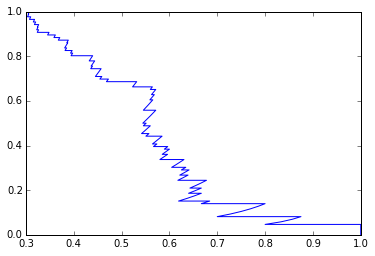

In [24]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.plot(precision,recall)

Существует метрика, которая позволять оценить модель в целом (для каждого порога). Она называется площадь под кривой точность-полнота или precision-recall auc.

In [25]:
from sklearn.metrics import average_precision_score
average_precision_score(y_test, y_pred)

0.56404304967723984

Чем ближе этот показатель к 1, тем лучше, т.е. сравнивая несколько моделей мы должны выбрать ту, у которой этот показатель выше. И кстати говоря в нашем случае - классы сильно несбалансированы - precision-recall кривая как раз самый подходящий индикатор для оценки качества модели.

Существует еще одна метрика качества, котрая называется roc_auc, т.е площать под кривой Receiver Operating Characteristic. Эта кривая строиться в двух измерениях: 
- доля неверно принятых объектов (False Positive Rate, FPR);
$$FPR= \frac{FP}{FP+TN} $$ 
- доля верно принятых объектов (True Positive Rate, TPR):
$$TPR= \frac{TP}{TP+FN}$$

Эти две доли тоже рассчитываются для каждого возможного порога.

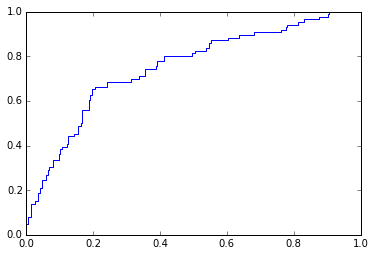

In [26]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test,y_pred)
plt.plot(fpr,tpr)

Теперь рассчитаем и площадь под этой кривой:

In [27]:
from sklearn.metrics import auc
auc(fpr,tpr)

0.75228211258422073

Здесь тоже самое - чем ближе этот показатель к 1, тем лучше.

На сегодня пока все! До новыйх встреч!)